# Final Project: Hermite RBF Interpolation Digital Inpainting
# SCC0251 - Processamento de Imagens
---

### Nome: Guilherme Valderramos Montroni
### Nº USP: 13062539
---


It is not new that radial basis functions are used in interpolation practices on meshes and surfaces. A very recurrent task, which has obtained extremely satisfactory results, is the reconstruction of implicit functions that interpolate surfaces with a high degree of accuracy (Macedo et al [[1]](https://www.visgraf.impa.br/Data/RefBib/PS_PDF/cgf2010/macedo-HRBFImplicits-CGF.pdf),[[2]](https://www.researchgate.net/publication/221337481_Hermite_Interpolation_of_Implicit_Surfaces_with_Radial_Basis_Functions)).

By interpreting the position of the pixels as a mesh and the values of the intensities being the known region under the mesh, we can calculate an interpolating function on the surface (S) that passes through each pixel in the image. Thus, our intention is to apply this practice to the digital painting process in order to reconstruct a degraded image.

<p align="center">
	<img align="center" width="220" height="200" src="https://user-images.githubusercontent.com/96217617/174624393-90260057-9741-45fa-a0a6-c553dd58bab6.png">

  <img align="center" width="340" height="220" src="https://user-images.githubusercontent.com/96217617/174624841-f00bdaea-7feb-4182-8558-a0bf8818815c.png">
</p>

The **Hermite RBF Interpolation Digital Inpainting** method takes as input a degraded image and a mask stating the region to be restored (by pattern we determine the black region as the retouch region).

In the step-by-step Hermite interpolation we need the existing pixel intensities (i.e. $x_i = \lambda_i f$) and the partial derivatives in the x and y direction (given by the gradient), being obtained in discrete form by finite differences.

$$
P_f(x) = \sum_{j=1}^N c_j \psi_j(||x||), \hspace{.5cm} x \in \mathbb{R}^S.
$$

$\psi_j$ is a radial basis function satisfying the interpolation condition $P_f$, where

$$
\lambda_i P_f = \lambda_i f \hspace{.5cm} i = 1, ..., N.
$$

With the intensity and its derivatives in hand, we can determine the Hermite RBF interpolating function by solving the linear system $Ac = P_f$, where $A$ is a matrix of the form:

<p align="center">
	<img align="center" width="650" height="280" src="https://user-images.githubusercontent.com/96217617/174632862-73b17d24-ab63-4c50-8307-63299ffbc8b2.png">

with $\xi_j$ the pixel degraded.  

Restoration happens when for each degraded pixel the *k* good pixels closest to the target pixel are selected using a multi-quadratic radial basis function. The process repeats until all pixels in the image are restored as the figure below illustrates.

<p align="center">
	<img align="center" width="600" height="300" src="https://user-images.githubusercontent.com/96217617/174633060-24d9e6cf-25fe-4c8c-b2d3-8de54c4b9ddc.png">

#**Packages**

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import numpy.matlib
from scipy.spatial import distance_matrix

#**Functions**

In [4]:
# NORMALIZE
def normalize(img, factor):
    img_min = np.min(img)                         # min of image
    img_max = np.max(img)                         # max of image
    img = (img - img_min)/(img_max-img_min)       # normalize of image between 0 and 1
    return (img*factor)

In [5]:
# RGB to Grayscale image
def rgb2gray(img):
    img = np.array(img, copy=True).astype(float)
    # computing conversion
    new_img = np.zeros((img.shape[0], img.shape[1]))
    new_img = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114  # Luminance conversion
    new_img = normalize(new_img, 255)

    return (new_img.astype(np.uint8))

In [6]:
# GRID 
def grid(mask):
  # Creates the image grid to determine the position of each pixel
  
  # shape image
  M,N = mask.shape                    

  # creating the grid
  x = np.linspace(0, M-1, M)
  y = np.linspace(0, N-1, N)
  X, Y = np.meshgrid(x, y)

  idx = np.flip(np.array([X.flatten(), Y.flatten()]).T,1).reshape(M,N,2)    # index of image

  return (idx)

In [7]:
# Pattern the Mask
def checkmask(mask):
  # standardizes the input masks
  # by pattern, the black region will be determined as the retouching area

  # number of elements black (false) and white (true)
  a = np.count_nonzero(mask == False)
  b = np.count_nonzero(mask == True)

  # if the mask has more than one layer 
  if len(mask.shape) == 3:
    # select the first layer
    mask = mask[:,:,0]

  # if the mask has more black pixels 
  # then the mask is inverted 
  if a > b:
    mask = ~mask

  return (mask)

In [8]:
# Euclidean Distance
def Euclidean_distance(p, q):
    dist = np.sqrt(np.sum(np.square(p-q)))
    return (dist)

In [9]:
def rhs_function(img, mask):
  # calculates the partial derivatives with respect to x and y (finite differences) of the good pixels 
  # and arranges into a vector, whose order is the value of the intensities, the partial derivatives 
  # with respect to x and the partial derivatives with respect to y respectively.

  # Single Color Channel (SCC)
  if (len(img.shape) == 2):
    gx, gy = np.gradient(img)                           # gradient calculation
    rhs = np.array([*img[mask], *gx[mask], *gy[mask]])  # rhs of scc image

  # RGB
  if (len(img.shape) == 3):
    gx, gy = np.gradient(img)                           # DÚVIDA P/ PRÓXIMA ETAPA 
    rhs = print('ainda não foi feito para imagem rbg')  # como calcular o gradiente de uma imagem colorida?
  
  return (rhs)

In [10]:
# Non-Damaged and Damaged Points
def non_and_damaged(img, mask):
  # determines the good and degraded region of the image.

  # by pattern, the degraded region is black
  nondamaged = img[mask]
  damaged = img[~mask]

  return (nondamaged, damaged)

In [11]:
# Hermite RBF Interpolation Digital Inpainting (GLOBAL METHOD)
def HRBF2D(dsites, epoints, rhs, kernel):

  # dsites (array Nx2): N given points where you have the function values (good pixels region).
  # epoints (array Mx2): M points where the interpolating function will be calculated (degraded region of the image)
  # rhs (array 3Nx1): values and derivatives of the function at dsites.
  # kernel: kernel for interpolation image.

    rbf, dxrbf, dyrbf, dxxrbf, dyyrbf, dxyrbf, ep = kernel['rbf'], kernel['dxrbf'], kernel['dyrbf'], kernel['dxxrbf'], kernel['dyyrbf'], kernel['dxyrbf'], kernel['ep']
    
    # Compute the distance and difference matrices for evaluation matrix
    DM_eval = distance_matrix(epoints, dsites)
    dx_eval = epoints[:,0].reshape(-1,1) - dsites[:,0].reshape(1,-1)
    dy_eval = epoints[:,1].reshape(-1,1) - dsites[:,1].reshape(1,-1)

    # Compute the distance and difference matrices for interpolation matrix
    DM_data = distance_matrix(dsites, dsites)
    dx_data = dsites[:,0].reshape(-1,1) - dsites[:,0].reshape(1,-1)
    dy_data = dsites[:,1].reshape(-1,1) - dsites[:,1].reshape(1,-1)

    # Compute blocks for interpolation matrix
    IM    = rbf(ep, DM_data)
    DxIM  = dxrbf(ep, DM_data, dx_data)
    DyIM  = dyrbf(ep, DM_data, dy_data)
    DxxIM = dxxrbf(ep, DM_data, dx_data)
    DyyIM = dyyrbf(ep, DM_data, dy_data)
    DxyIM = dxyrbf(ep, DM_data, dx_data, dy_data)

    IM = np.block([[IM,   -DxIM,  -DyIM],
                   [DxIM, -DxxIM, -DxyIM],
                   [DyIM, -DxyIM, -DyyIM]])

    # Compute blocks for evaluation matrix
    EM    = rbf(ep, DM_eval)
    DxEM  = dxrbf(ep, DM_eval, dx_eval)
    DyEM  = dyrbf(ep, DM_eval, dy_eval)

    # Assemble evaluation matrix
    EM = np.block([EM, -DxEM, -DyEM])

    # RBF Hermite interpolant
    alpha = np.linalg.solve(IM, rhs)
    return (EM @ alpha)

#**Input**

The HRBF method takes as input a degraded image with its respective mask that specifies the retouching region.

Text(0.5, 1.0, 'Example of Mask Image')

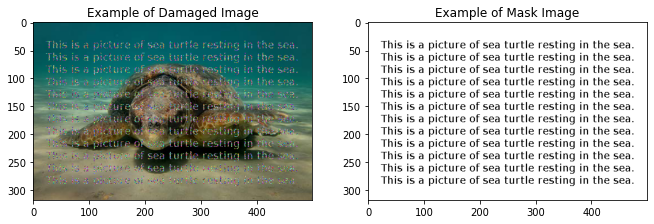

In [10]:
# example image
eximg = imageio.imread('dataimage/transport_input.png').astype(np.uint8) 
exmask = imageio.imread('dataimage/transport_mask.png').astype(np.uint8)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(eximg, cmap="gray"); plt.title("Example of Damaged Image") 

plt.subplot(122)
plt.imshow(exmask, cmap="gray"); plt.title("Example of Mask Image")

#**Tests**

At this point I still have some doubts about how to calculate the gradient for color images in this way, for this reason we will only work with grayscale images.

##**Test 1 - Synthetic Image**

In [11]:
#filename = str(input().rstrip())                                                    # file of input image
originalimg = imageio.imread('dataimage/cahn_hilliard_clean.png').astype(np.uint8)   # uint8 elements

#filename = str(input().rstrip())                                                    # file of input image
degradedimg = imageio.imread('dataimage/cahn_hilliard_input.png').astype(np.uint8)   # uint8 elements

#filename = str(input().rstrip())                                                    # file of input mask
mask = imageio.imread('dataimage/cahn_hilliard_mask.png').astype(bool)               # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

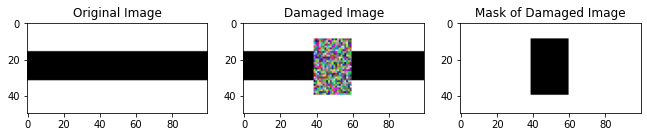

In [12]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

Conversion to grayscales,

Text(0.5, 1.0, 'Damaged Image')

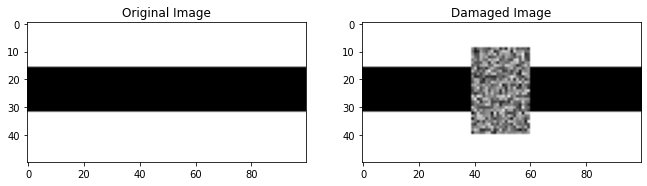

In [13]:
originalimg = rgb2gray(originalimg)
degradedimg = rgb2gray(degradedimg)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

Applying the HRBF method,

In [14]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid(mask)                                        # grid of image
dsites = idx[mask]                                      # position of good pixels region
epoints = idx[~mask]                                    # position of degraded region of the image
rhs = rhs_function(degradedimg, mask)                   # intensity values and their derivatives

# HRBF2D Interpolation
result_image = HRBF2D(dsites, epoints, rhs, kernel)

# Update image
degradedimg[~mask] = result_image

During the inpainting process of the HRBF method it is seen that the memory RAM consumption and the computational time are very high, this is exclusively due to the calculation of the hermite interpolation, which is done on all good pixels (the number of good pixels in the image below) of the image, that is, the calculation is done globally. However, we can concentrate the interpolation calculation only on the good pixels near the degraded region and generate an interpolating function for each degraded pixel, since they are the ones that will interfere with the interpolation function.

In [15]:
print('good pixels of the image', degradedimg[mask].shape[0])

good pixels of the image 4349


In the resulting image you can see that near the edges the expected result was not obtained. Probably:

- This happened because the image has an abrupt change in intensity, so, as we are using an interpolation process, the image ends up being smoothed and, the edge regions end up suffering this impact.

Text(0.5, 1.0, 'Result Image')

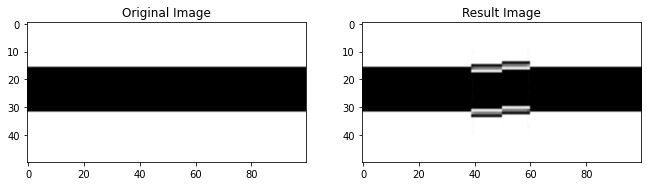

In [16]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(122)
plt.imshow(degradedimg, cmap="gray"); plt.title("Result Image")

**Possible solutions** to the problem of inpainting on textured images:

- Use techniques seen in class, such as Local Binary Patterns (LBP).

- Inpainting in order of priority  [(Wang et al)](https://www.sciencedirect.com/science/article/abs/pii/S0925231213006334).

**ps:** I accept other suggestions for this correction.

##**Test 2 - Smooth Images**

For this second test, we reserve smooth images.

In [12]:
#filename = str(input().rstrip())                                       # file of input image
originalimg = imageio.imread('dataimage/walk.png').astype(np.uint8)     # uint8 elements

#filename = str(input().rstrip())                                       # file of input image
degradedimg = imageio.imread('dataimage/walk1.png').astype(np.uint8)    # uint8 elements

#filename = str(input().rstrip())                                       # file of input mask
mask = imageio.imread('dataimage/walk2.png').astype(bool)               # logical elements
# Pattern the Mask
mask = checkmask(mask)

Text(0.5, 1.0, 'Mask of Damaged Image')

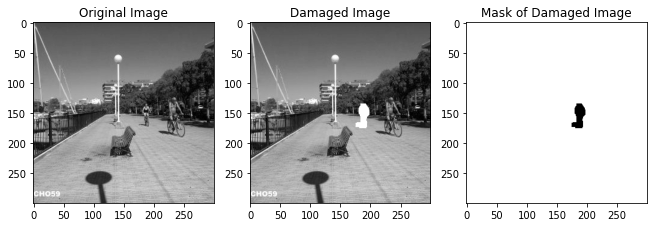

In [13]:
originalimg = rgb2gray(originalimg)
degradedimg = rgb2gray(degradedimg)

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimg, cmap="gray"); plt.title("Original Image")

plt.subplot(132)
plt.imshow(degradedimg, cmap="gray"); plt.title("Damaged Image") 

plt.subplot(133)
plt.imshow(mask, cmap="gray"); plt.title("Mask of Damaged Image")

In the removal process we will simulate a smaller region of the original image such that it preserves all the degraded region of the image in order to select a smaller set of good pixels for generating the interpolating function.

Note that the selection of the good pixels that would be used was done manually, but for a next step we thought about using a morphological process. Erosion/Dilation in the mask to determine a region close to the edge and then apply the difference to the original mask so that only one region remains at the edge of the mask that will be used to determine the interpolating function, improving the computational cost.

Text(0.5, 1.0, 'Small Size Mask of Damaged Image')

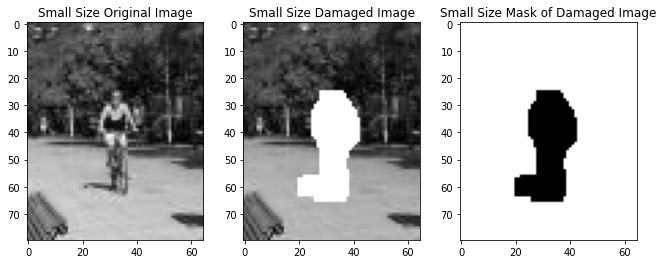

In [14]:
# Image Slices
originalimgsize = originalimg[110:190, 155:220]
degradedimgsize = degradedimg[110:190, 155:220]
masksize = mask[110:190, 155:220]

## plotting
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(originalimgsize, cmap="gray"); plt.title("Small Size Original Image")

plt.subplot(132)
plt.imshow(degradedimgsize, cmap="gray"); plt.title("Small Size Damaged Image") 

plt.subplot(133)
plt.imshow(masksize, cmap="gray"); plt.title("Small Size Mask of Damaged Image")

Applying the HRBF method,

In [15]:
# RBFHermite 2D
# Script that performs first-order 2D RBF Hermite interpolation

# Define RBF and its derivatives
kernel = {'rbf':    lambda e, r:         np.sqrt(1 + (e * r)**2),
          'dxrbf':  lambda e, r, dx:     dx * e**2 / np.sqrt(1 + (e * r)**2),
          'dyrbf':  lambda e, r, dy:     dy * e**2 / np.sqrt(1 + (e * r)**2),
          'dxxrbf': lambda e, r, dx:     e**2 * (1 + (e * r)**2 - (e * dx)**2) / (1 + (e * r)**2)**(3/2),
          'dyyrbf': lambda e, r, dy:     e**2 * (1 + (e * r)**2 - (e * dy)**2) / (1 + (e * r)**2)**(3/2),
          'dxyrbf': lambda e, r, dx, dy: -e**4 * dx * dy / (1 + (e * r)**2)**(3/2),
          'ep': 6}

idx = grid(masksize)                                        # grid of image
dsites = idx[masksize]                                      # position of good pixels region
epoints = idx[~masksize]                                    # position of degraded region of the image
rhs = rhs_function(degradedimgsize, masksize)               # intensity values and their derivatives

# HRBF2D Interpolation
result_image = HRBF2D(dsites, epoints, rhs, kernel)

# Update image
degradedimgsize[~masksize] = result_image

process result,

Text(0.5, 1.0, 'Small Size Result Image')

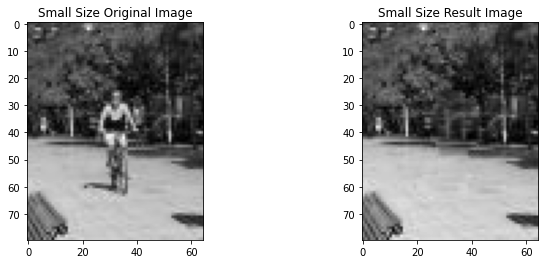

In [16]:
## plotting
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.imshow(originalimgsize, cmap="gray"); plt.title("Small Size Original Image")

plt.subplot(122)
plt.imshow(degradedimgsize, cmap="gray"); plt.title("Small Size Result Image")

Note that for soft images the HRBF method became effective as expected, completely removing the object from the image leaving it looking natural.

#**Questions**

This space was reserved for some questions to be answered through the project orientation and by me during the research.

- How can I calculate the gradient of a color image ?

- Is a mask dilation process a good option to determine the good pixel region near the edge of the degraded region to generate the interpolating function?

- For now the HRBF method paints all pixels of the image by a single interpolating function, so it does not use the restored pixels in the function calculation. Perhaps using these restored pixels and generating a new function with each iterative process could improve the results?

#**Next Steps**

RBG process:

- Implement the rbg version of the method.

Improve the computational cost:

- Put a process to generate the hermite interpolator function only near the degraded region of the image.

- Generate an interpolating function for each degraded pixel, thus making a local calculation.

Textured Images:

- Maybe an implementation for textured images or a calculation of the degraded pixels by priority.